                                           Recommendation System: Collaborative Filtering

## Librairies Import

In [3]:
import pandas as pd
import numpy as np
import seaborn as sea
import matplotlib.pyplot as plt
import os
from scipy.stats import ttest_ind
import warnings

In [4]:
SEED=42
np.random.seed(SEED)
warnings.filterwarnings(action='ignore')

## Data Loading 

In [6]:
items=pd.read_csv(os.path.join('data','items.csv'))
users=pd.read_csv(os.path.join('data','user.csv'))
votes=pd.read_csv(os.path.join('data','votes.csv'))

MUI=votes.pivot(index='user.id',columns='item.id',values='rating').fillna(0)

## Data Analysis

**Overview of the data**

In [9]:
print("Overview of items : ")
display(items.head())
print()
print("Overview of users : ")
display(users.head())
print()
print("Overview of votes : ")
display(votes.head())

Overview of items : 


,movie.id,movie.title,release.date,video.release.date,IMDb.URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0



Overview of users : 


,id,age,gender,job,zip
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213



Overview of votes : 


,user.id,item.id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


**Number of users,items and rating**

In [11]:
print(f"Total Number of users : {users['id'].nunique()}")
print(f"Total Number of items : {items['movie.id'].nunique()}")
print(f"Total Number of votes : {len(votes)}")

Total Number of users : 943
Total Number of items : 1682
Total Number of votes : 100000


**Histogram of given ratings**

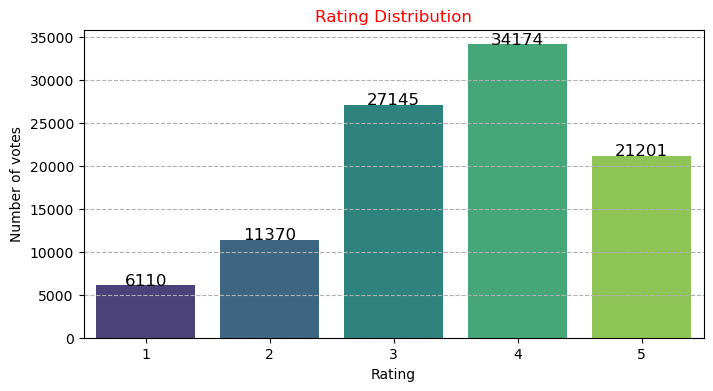

In [13]:
# Setting the size of the figure  (width=8 , height=4)
plt.figure(figsize=(8,4))
# creating a counplot to display the frequency of each rating value 
ax=sea.countplot(data=votes,x='rating',palette='viridis')
for p in ax.patches:
    height=p.get_height()
    width=p.get_width()
    x=p.get_x()
    ax.text(x=x+width/2,y=height+30,s=f"{int(height)}",fontsize=12,ha='center')

ax.set_xlabel("Rating")
ax.set_ylabel("Number of votes")
ax.set_title("Rating Distribution",c='r')
plt.grid(visible=True,axis='y',linestyle='--')

Analysis : 

- Asymetric distribution with a higher concentration on high ratings (rating 4 is the most frequent).
- Users tends to avoid giving low ratings which is a common pattern is recommendation systems where people are more likely to rate items when they enjoy.(Warning: Low scores are underrepresented which may lead to over-recommendation of highly rated items  and will likely require some form of score normalization.

Note : Rebalancing could be considered.Possible strategies include : 
- Normalizing rating per user
- Binarizing interactions
- Giving more weight to low rating during the optimisation process.


**Top10 Most Rated Items**

Text(0, 0.5, 'Items')

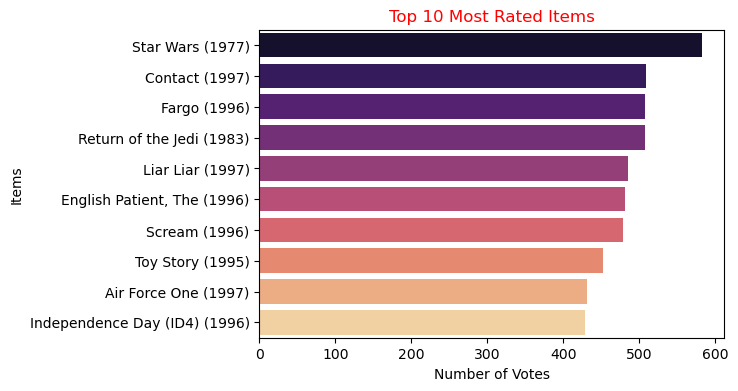

In [16]:
top10_items_votes=votes['item.id'].value_counts().head(10)
indexes=list(top10_items_votes.index) # Extracting the corresponding item-ids
movies_name=[items.loc[items['movie.id']==index,'movie.title'].iloc[0] for index in indexes] # Retrieving the movie titles associated with each item id
plt.figure(figsize=(6,4))
sea.barplot(x=top10_items_votes,y=movies_name,palette='magma')

plt.title('Top 10 Most Rated Items',c='r')
plt.xlabel('Number of Votes')
plt.ylabel('Items')



Analysis: 
Star Wars has the higher number of votes, suggesting that these movies may be over-recommended due to popularity bias. To mitigate this, it may become necessary to penalize popular items by reducing their influence in the recommendation process, for example, using TF-IDF weighting or amplification techniques. Using these adjustments is important for helping to preserve recommendation diversity and avoid reinforcing already dominant items. 

**Top 10 Most Actif Users**

Text(0, 0.5, 'Id User')

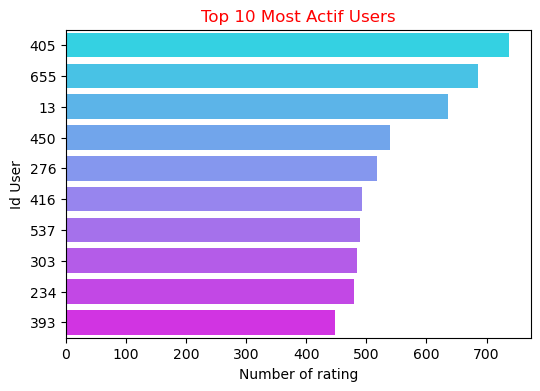

In [19]:
top10_users_votes=votes['user.id'].value_counts().head(10)
indexes=(top10_users_votes.index) # Extracting the corresponding user-ids
plt.figure(figsize=(6,4))
sea.barplot(x=top10_users_votes,y=indexes.astype(str),palette='cool')

plt.title('Top 10 Most Actif Users',c='r')
plt.xlabel('Number of rating')
plt.ylabel('Id User')



Analysis: 
The user with ID 405 has submitted over 700 ratings, significantly above average. Moreover, the top 10 users have rated at least 450 items , classifying them as power users or experts within the system. This also shows a user activity imbalance, where a small subset of users generates a large portion of interactions. These profiles may dominate the UI matrix and bias the model toward their specific preferences, potentially leading to overfitting.

Note: (We may use weighting mechanisms to reduce their disproportionate influence during model training).

**HeatMap MUI**

Text(95.72222222222221, 0.5, 'User Id')

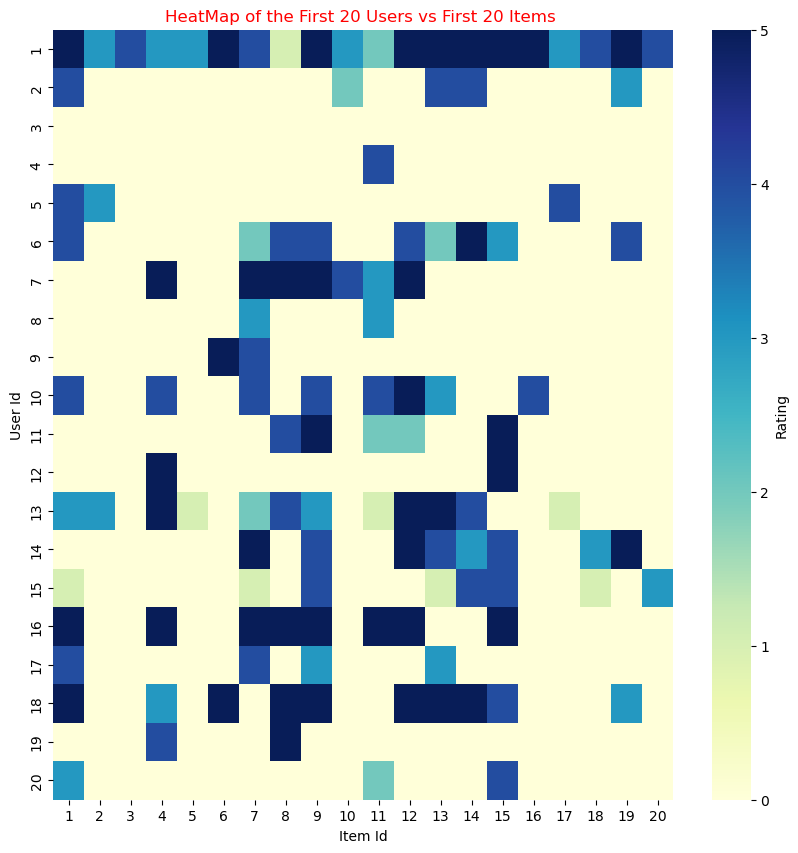

In [22]:
plt.figure(figsize=(10,10))
# Plotting a HeatMap of the first 20 users and 20 items from the MUI
sea.heatmap(data=MUI.iloc[:20,:20],cmap='YlGnBu',cbar_kws={'label':'Rating'})


plt.title("HeatMap of the First 20 Users vs First 20 Items ",c='r')
plt.xlabel('Item Id')
plt.ylabel('User Id')

Analysis: 

The UI matrix exhibits a high number of 0s, showing a common issue in recommendation systems: matrix sparsity. The sparsity arises because users typically rate only a small fraction of available items, introducing challenges in computing similarities and reducing the robustness of predictions.

To address this, it might be beneficial to apply matrix factorization techniques such as SVD, NMF, ALS, or gradient-based factorization methods, which are well suited for handling sparse interaction data.

## Simple Baseline Methods

Why?

- Provides a reference point for evaluating more advanced methods (e.g., matrix factorization or NN)
- It helps detect issues such as sparsity, imbalance, or extreme ratings
- Ensure proper Functioning of evaluation metrics

The performance of these methods will be compared with and without cross-validation. Initially, this will give us a quick estimates of the performance across different methods and allow for easy comparison. In a second stage, it will help measure the robustness of our approach,reduce the risk of overfitting, obtain a more reliable performance evaluation, and stimulate the behavior of multiple users. The cross-validation that will be implemented is the 5-fold KFold.

**Errors calculation Functions**

In [27]:
def RMSE(y_true,y_pred):
    return np.sqrt(np.nanmean((y_true-y_pred)**2))

def MAE(y_true,y_pred):
    return np.nanmean(np.abs(y_true-y_pred))

# Transformation of the UI matrix into numpy format + Flatten to make later calculation

MUI_numpy=MUI.to_numpy()
MUI_numpy_flatten=MUI_numpy.flatten()


**Performance calculation of the methods without cross-validation**

In [29]:
## Vote aléatoire 
# Generating random numbers between min and max rating : 
min_v=np.min(votes['rating'])
max_v=np.max(votes['rating'])
random_vote=np.random.randint(low=min_v,high=max_v+1,size=MUI_numpy.shape)
print("Error calculation for random vote : ")
print(f'RMSE for random vote :{RMSE(MUI_numpy,random_vote)}')
print(f"MAE for random vote : {MAE(MUI_numpy,random_vote)} ")
## Mean Vote
global_mean=np.nanmean(votes['rating'])
mean_votes=np.full(shape=MUI_numpy.shape,fill_value=global_mean,dtype=int)
print("------------------------------------------")
print("Error calculation for Mean Vote : ")
print(f'RMSE for mean vote :{RMSE(MUI_numpy,mean_votes)}')
print(f"MAE for mean vote : {MAE(MUI_numpy,mean_votes)}")
## User Mean Vote 
user_mean=np.nanmean(MUI_numpy,axis=1)
mean_vote_user=np.tile(np.reshape(user_mean,(-1,1)),(1,MUI_numpy.shape[1]))
print("------------------------------------------")
print("Error calculation for User Mean Vote :")
print(f'RMSE for User Mean Vote :{RMSE(MUI_numpy,mean_vote_user)}')
print(f"MAE for User Mean Vote : {MAE(MUI_numpy,mean_vote_user)}")
## Item Mean Vote
item_mean=np.nanmean(MUI_numpy.T,axis=1)
item_mean_vote=np.tile(item_mean,(MUI_numpy.shape[0],1))
print("---------------------------------------------")
print("Error calculation for Item Mean Vote :")
print(f'RMSE for Item Mean Vote :{RMSE(MUI_numpy,item_mean_vote)}')
print(f"MAE for Item Mean Vote : {MAE(MUI_numpy,item_mean_vote)}")
## Expected Mean Vote
expected_mean_vote=1/2*(mean_vote_user+item_mean_vote)
print("----------------------------------------")
print("Error calculation for Expected Mean Vote :")
print(f'RMSE for Expected Mean Vote : {RMSE(MUI_numpy,expected_mean_vote)}')
print(f"MAE for Expected Mean Vote : {MAE(MUI_numpy,expected_mean_vote)}")
liste_rmse_no_cross=[RMSE(MUI_numpy,random_vote),RMSE(MUI_numpy,mean_votes),RMSE(MUI_numpy,mean_vote_user),RMSE(MUI_numpy,item_mean_vote),RMSE(MUI_numpy,expected_mean_vote)]
liste_mae_no_cross=[MAE(MUI_numpy,random_vote),MAE(MUI_numpy,mean_votes),MAE(MUI_numpy,mean_vote_user),MAE(MUI_numpy,item_mean_vote),MAE(MUI_numpy,expected_mean_vote)]

Error calculation for random vote : 
RMSE for random vote :3.2449198128290777
MAE for random vote : 2.9060736662787194 
------------------------------------------
Error calculation for Mean Vote : 
RMSE for mean vote :2.9206452152520597
MAE for mean vote : 2.8740112702269554
------------------------------------------
Error calculation for User Mean Vote :
RMSE for User Mean Vote :0.8799017568877189
MAE for User Mean Vote : 0.3931249181864198
---------------------------------------------
Error calculation for Item Mean Vote :
RMSE for Item Mean Vote :0.8420031919443053
MAE for Item Mean Vote : 0.36213007935837777
----------------------------------------
Error calculation for Expected Mean Vote :
RMSE for Expected Mean Vote : 0.8393083322140868
MAE for Expected Mean Vote : 0.3774504831100592


Initial comments based on the results obtained
- Methods that calculate averages to predict ratings perform better than those that randomly generate ratings
- The most accurate method is the one that combines both user and item averages
- RMSE is higher than MAE for all the methods used. However, the gap between the two decreases for the most accurate methods, showing that when a method is more precise, it also produces fewer large errors.

**Performance calculation of the methods with cross-validation**

In [32]:
## create ind for different values of np.nan
indices=np.arange(0,MUI_numpy.shape[0]*MUI_numpy.shape[1])
indices_na=indices[~np.isnan(MUI_numpy_flatten)]
## Train test split of the indices
nbre_replis=5
np.random.shuffle(indices_na)
idx_split = np.array_split(indices_na, nbre_replis)
print(indices_na.shape)

(1586126,)


In [33]:
# Initialization of the results list
list_RMSE=[]
list_MAE=[]

for i in range(0,nbre_replis):
    # Manual merging of indices from the other fold to create the training set
    idx_train=np.concatenate([idx_split[j] for j in range(nbre_replis) if j!=i])
    idx_test=idx_split[i]

    # Independant copies of the flattened matrix
    MUI_numpy_train=MUI_numpy_flatten.copy()
    MUI_numpy_test=MUI_numpy_flatten.copy()

    # Remove the test-vals from the training matrix and vice-versa
    MUI_numpy_train[idx_test]=np.nan
    MUI_numpy_test[idx_train]=np.nan

    # Reshape into U-I matrix
    MUI_numpy_train=MUI_numpy_train.reshape(MUI_numpy.shape)
    MUI_numpy_test=MUI_numpy_test.reshape(MUI_numpy.shape)

    # Checking the dimensions
    print(MUI_numpy_train.shape)
    print(MUI_numpy_train[~np.isnan(MUI_numpy_train)].shape)
    print(MUI_numpy_test[~np.isnan(MUI_numpy_test)].shape)

    # ------------------ Predictions on test values------------------

    ##  Random vote
    min_v=np.nanmin(votes['rating'])
    max_v=np.nanmax(votes['rating'])
    votes_alea_pred=np.random.randint(low=min_v,high=max_v+1,size=MUI_numpy_test.shape)

    ## Global Mean Vote
    global_mean=np.nanmean(MUI_numpy_train)
    empty_columns=np.where(np.sum(~np.isnan(MUI_numpy_train),axis=0)==0)[0]
    for col in empty_columns:
        MUI_numpy_train[:,col]=global_mean
    votes_moyenne_pred=np.full(MUI_numpy_test.shape,global_mean)

    ## User Mean Vote
    user_means=np.nanmean(MUI_numpy_train,axis=1)
    user_means=np.where(np.isnan(user_means),global_mean,user_means).reshape(-1,1)
    votes_moyenne_U_pred=np.tile(user_means,(1,MUI_numpy_test.shape[1]))

    ## Item Mean Vote
    item_means=np.nanmean(MUI_numpy_train,axis=0)
    item_means=np.where(np.isnan(item_means),global_mean,item_means)
    votes_moyenne_I_pred=np.tile(item_means,(MUI_numpy_test.shape[0],1))

    ## Expected Mean Vote
    moyenne_U_repeat=np.tile(user_means,(1,MUI_numpy_test.shape[1]))
    moyenne_I_repeat=np.tile(item_means,(MUI_numpy_test.shape[0],1))
    votes_moyenne_A_pred=0.5*(moyenne_U_repeat+moyenne_I_repeat)

    ## Evaluation
    list_matrices=[votes_alea_pred,votes_moyenne_pred,votes_moyenne_U_pred,votes_moyenne_I_pred,votes_moyenne_A_pred]
    list_RMSE.append(np.array([RMSE(mat,MUI_numpy_test) for mat in list_matrices]))
    list_MAE.append(np.array([MAE(mat,MUI_numpy_test) for mat in list_matrices]))

list_RMSE=np.array(list_RMSE)
list_MAE=np.array(list_MAE)
print("\n Results for Random Vote : ")
print("RMSE :",list_RMSE.mean(axis=0)[0])
print("MAE :",list_MAE.mean(axis=0)[0],'\n')

print("Results for Global Mean Vote :")
print("RMSE :",list_RMSE.mean(axis=0)[1])
print("MAE :",list_MAE.mean(axis=0)[1],'\n')

print("Results for User Mean Vote :")
print("RMSE :",list_RMSE.mean(axis=0)[2])
print("MAE :",list_MAE.mean(axis=0)[2],'\n')

print("Results for Item Mean Vote :")
print("RMSE :",list_RMSE.mean(axis=0)[3])
print("MAE :",list_MAE.mean(axis=0)[3],'\n')

print("Results for Expected Mean Vote  :")
print("RMSE :",list_RMSE.mean(axis=0)[4])
print("MAE :",list_MAE.mean(axis=0)[4],'\n')

(943, 1682)
(1268900,)
(317226,)
(943, 1682)
(1268901,)
(317225,)
(943, 1682)
(1268901,)
(317225,)
(943, 1682)
(1268901,)
(317225,)
(943, 1682)
(1268901,)
(317225,)

 Results for Random Vote : 
RMSE : 3.2463512865271227
MAE : 2.9076908145015397 

Results for Global Mean Vote :
RMSE : 0.9032777788068321
MAE : 0.41703077645013764 

Results for User Mean Vote :
RMSE : 0.8804780508267269
MAE : 0.39335969655369435 

Results for Item Mean Vote :
RMSE : 0.8430056861585282
MAE : 0.36250298600537123 

Results for Expected Mean Vote  :
RMSE : 0.8400386396986486
MAE : 0.37775421141378207 



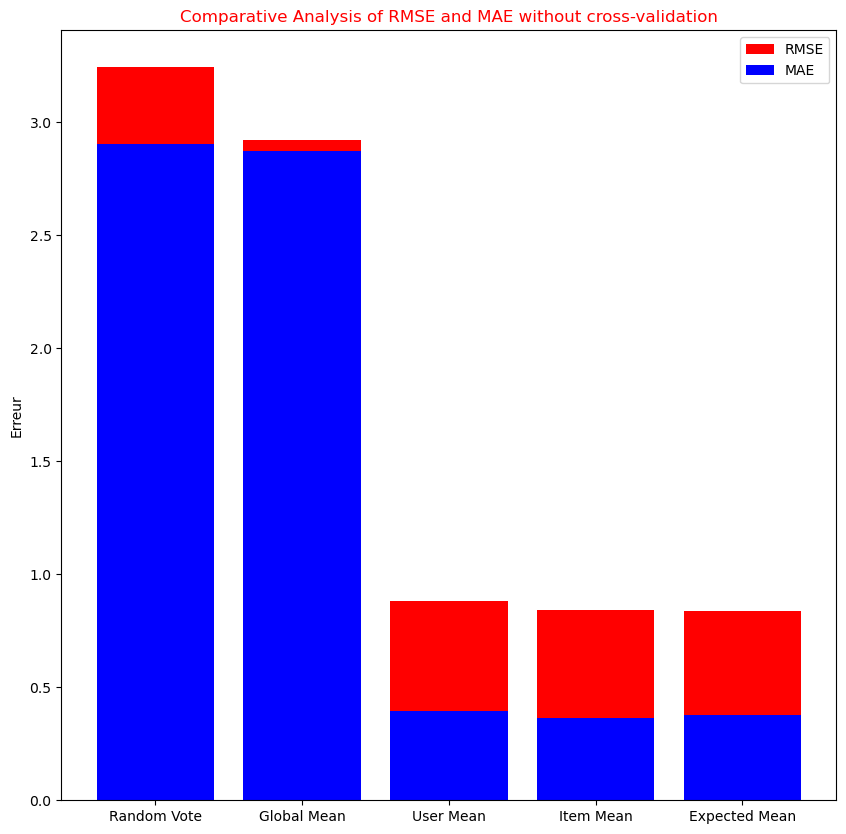

In [34]:
methodes=['Random Vote','Global Mean','User Mean','Item Mean','Expected Mean']
plt.figure(figsize=(10,10))
plt.bar(methodes,liste_rmse_no_cross,color='red',label='RMSE')
plt.bar(methodes,liste_mae_no_cross,color='blue',label='MAE')
plt.ylabel('Erreur')
plt.title('Comparative Analysis of RMSE and MAE without cross-validation',c='red')
plt.legend()

Without cross-validation: Random voting produces the highest errors, which is consistent since it relies on no information from the data. It serves as a naïve baseline.

Global mean voting significantly improves results by capturing a general trend in the ratings. However, this method remains limited because it does not account for individual differences between users or item-specific characteristics.

User mean and item mean methods provide welcome personalization. Item mean voting stands out slightly, which can be explained by greater stability in behaviors associated with items compared to the sometimes-variable preferences of users.

Finally, the expected mean vote, which combines user preferences and item profiles, is the most effective method. It benefits from double personalization and provides the most accurate predictions without cross-validation.

With cross-validation: This step aims to test the robustness of methods when the training data changes. It is observed that the performance of random voting and global mean voting remains almost unchanged, indicating that they are not influenced by the distribution of training data.

In contrast, the performance of user mean voting, item mean voting, and expected mean voting decreases slightly. This drop is logical, as these methods rely heavily on the data available for each fold. It also reflects a more reliable estimation of their true effectiveness on new data.

**Hypothesis Test**

We want to determine wheter the difference between the RMSE obtained by the Item Mean Vote and the User Mean Vote is statistically significant.We perform a hypothesis test for this purpose.

- H0 : There is no significant difference between the RMSE of the two methods.
- H1 : There is a significant difference between the RMSE of the two methods.

In [38]:
## RMSE obtained using cross-validation for User vote and Item vote
rmse_vote_user=[list_RMSE[i][2] for i in range(0,nbre_replis)]
rmse_vote_item=[list_RMSE[i][3] for i in range(0,nbre_replis)]

rmse_vote_user=np.array(rmse_vote_user)
rmse_vote_item=np.array(rmse_vote_item)

## Sample Size
n_user=len(rmse_vote_user)
n_items=len(rmse_vote_item)

## Mean Calculation
mean_user=np.mean(rmse_vote_user)
mean_item=np.mean(rmse_vote_item)

## Std Calculation
std_user=np.std(rmse_vote_user,ddof=1)
std_item=np.std(rmse_vote_item,ddof=1)

 ## t-statistic calculation
t_stat=(mean_user-mean_item)/np.sqrt((std_user**2/n_user)+(std_item**2/n_items))

 ## Degree of Freedom calculation 
degree_of_freedom=((std_user**2/n_user)+(std_item**2/n_items))**2 / ((std_user**2/n_user)**2/(n_user-1))+((std_item**2/n_items)**2/(n_items-1))

 ##  p value for a two-tailed test
 ## using Student's table distribution
t_distribution=pd.Series(np.linspace(-5,5,100000))
cdf_val=(1+np.sign(t_distribution)*(1-np.exp(-t_distribution**2 /2)))/ 2
closest_index = np.abs(t_distribution - t_stat).argmin()
p_value=2*(1-cdf_val[closest_index])

print(f"T-Statistic : {t_stat}")
print(f"p-value : {p_value}")

T-Statistic : 21.944545622744617
p-value : 3.7266531720536733e-06


Comment : 

We observe that p-value <0.05 allowing us to conclude that the difference between the RMSE obtained from the Item Mean Vote and User Mean Vote is statistically highly significant, thus leading to the rejection of the null hypothesis. The Item Mean Vote has a lower RMSE than the User Mean Vote, and there is a significant difference between the RMSE values of the two methods. Therefore, in this case, it would be more appropriate to favor the Item Mean Vote method.

## Collaborative Filter

In [41]:
# cosine similarity between the row vectors of matrix A and the row vector of matrix B 
def cosinus_matrices(A:np.ndarray,B:np.ndarray):
    # Copy to avoid modifying the original values 
    A=A.copy()
    B=B.copy()
    # Replace Nans with 0 in order to avoid introducing more Nans with matrix product
    A[np.isnan(A)]=0
    B[np.isnan(B)]=0
    # Column matrix of the norms of each vector in A
    col_norm_A=np.sqrt(np.sum(A**2,axis=1)).reshape(-1,1)
    col_norm_A[col_norm_A==0]=1e-10
    # row matrix of the norms of each vector in B 
    col_norm_B=np.sqrt(np.sum(B**2,axis=1)).reshape(1,-1)
    col_norm_B[col_norm_B==0]=1e-10
    # cosine similarity computation 
    cos_sim=np.dot(A,B.T)/np.matmul(col_norm_A,col_norm_B)

    return cos_sim
    


In [42]:
def filtre_collaboratif(V,W):
    """
    Applies a collaborative filtering approach based on similarity weighting to predict the missing ratings
    """
    # create a boolean matrix with same size as V
    # Elements that are not Nan in V are marked with 1 and nan elements with 0
    # matrix ensures that only existing ratings contributes to the prediction 
    Bool_m=(~np.isnan(V))*1
    W=W.copy()
    V=V.copy()
    # Replacing Nan values in V and W with 0 (it allows matrix operations to be performed without errors)
    W[np.isnan(W)]=0
    V[np.isnan(V)]=0
    # Computing the sum of absolute sim for each user but only for the items they have rated (thanks to Bool_m)
    K=np.dot(np.abs(W),Bool_m)
    K[K==0]=1e-10   # Replacing 0 with a very small number to avoid the problem of dividing by 0
    # Computing the predicted rating 
    rating_pred=np.dot(W,V)/K
    # Restore Nans in the positions where there were no initial ratings 
    rating_pred[np.isnan(Bool_m)]=np.nan

    return rating_pred
    


**Performance calculation of the methods without cross-validation**

In [44]:
# Computation of cosine similarity (U-U)
W=cosinus_matrices(MUI_numpy,MUI_numpy)
# Application of U-I collaborative filtering 
user_pred=filtre_collaboratif(MUI_numpy,W)
# Computation of cosine similarity (I-I)
W_item=cosinus_matrices(MUI_numpy.T,MUI_numpy.T)
# Application of I-I collaborative filtering 
item_pred=filtre_collaboratif(MUI_numpy.T,W_item).T
# Computation of MAE and RMSE
mae_user=MAE(user_pred,MUI_numpy)
rmse_user=RMSE(user_pred,MUI_numpy)
mae_item=MAE(item_pred,MUI_numpy)
rmse_item=RMSE(item_pred,MUI_numpy)

print("Performance metrics for collaborative filtering : ")
print("User Based collaborative filtering : ")
print(f"MAE = {mae_user}")
print(f"RMSE= {rmse_user}")
print()
print("Item Based collaborative filtering : ")
print(f"MAE = {mae_item}")
print(f"RMSE = {rmse_item}")

mae_nocross_user=mae_user
rmse_nocross_user=rmse_user
mae_nocross_item=mae_item
rmse_nocross_item=rmse_item

Performance metrics for collaborative filtering : 
User Based collaborative filtering : 
MAE = 0.36062151742674914
RMSE= 0.7953288232879233

Item Based collaborative filtering : 
MAE = 0.44975968035203323
RMSE = 0.844929425033446


**Performance calculation of the methods with cross-validation**

In [46]:
# Initialization of lists for metrics
list_RMSE_CF = []
list_MAE_CF = []

for i in range(0,nbre_replis):
    ## Construction of training and test indices
    idx_train = [idx for j, idx in enumerate(idx_split) if j != i]
    idx_train = np.concatenate(idx_train)


    ## Copy of the complete matrix for train and test
    MUI_numpy_train = MUI_numpy_flatten.copy()  # Training index list
    MUI_numpy_test = MUI_numpy_flatten.copy()  # Test index list

    ## Removal of test values from the training matrix and vice-versa
    MUI_numpy_train[idx_test] = np.nan
    MUI_numpy_test[idx_train] = np.nan

    # Reshaping in order to restaure the matrix structure for train and test
    MUI_numpy_train = MUI_numpy_train.reshape(MUI_numpy.shape)
    MUI_numpy_test = MUI_numpy_test.reshape(MUI_numpy.shape)

    # --------------------------------- Collaborative Filtering ---------------------------------
    # Computation of U-U similarity
    W_user = cosinus_matrices(MUI_numpy_train, MUI_numpy_train)

    # Predictions U-U
    user_pred = filtre_collaboratif(MUI_numpy_train, W_user)

    # Computation of I-I similarity
    W_item = cosinus_matrices(MUI_numpy_train.T, MUI_numpy_train.T)

    # Predictions I=I
    item_pred = filtre_collaboratif(MUI_numpy_train.T, W_item).T

    # metrics calculation for U-U
    rmse_user = RMSE(user_pred, MUI_numpy_test)
    mae_user = MAE(user_pred, MUI_numpy_test)

    # metrics calculation for I-I
    rmse_item = RMSE(item_pred, MUI_numpy_test)
    mae_item = MAE(item_pred, MUI_numpy_test)


    list_RMSE_CF.append([rmse_user, rmse_item])
    list_MAE_CF.append([mae_user, mae_item])

# Conversion of results to numpy array for global calculation
list_RMSE_CF = np.array(list_RMSE_CF)
list_MAE_CF = np.array(list_MAE_CF)

# Résultats globaux
print("Results for user-based collaborative filtering :")
print(f"Average RMSE : {list_RMSE_CF.mean(axis=0)[0]:.4f}")
print(f"Average  MAE : {list_MAE_CF.mean(axis=0)[0]:.4f}\n")

print("Results for item-based collaborative filtering :")
print(f"Average RMSE : {list_RMSE_CF.mean(axis=0)[1]:.4f}")
print(f"Average  MAE : {list_MAE_CF.mean(axis=0)[1]:.4f}\n")

Results for user-based collaborative filtering :
Average RMSE : 0.7938
Average  MAE : 0.3599

Results for item-based collaborative filtering :
Average RMSE : 0.8437
Average  MAE : 0.4482



The results obtained for collaborative filtering show clear differences between the user-based and item-based approaches. For user-based collaborative filtering, the model achieves an average MAE of 0.3606 and an average RMSE of 0.7953, reflecting good predictive accuracy with few large errors. The moderate gap between the two metrics suggests that significant errors are rare.

For item-based collaborative filtering, the performance is slightly lower, with an average MAE of 0.4482 and an average RMSE of 0.8437, indicating greater variability in predictions.

Overall, the user-based approach appears to be slightly more accurate and consistent, while the item-based approach, although stable, shows a slightly higher dispersion of errors.

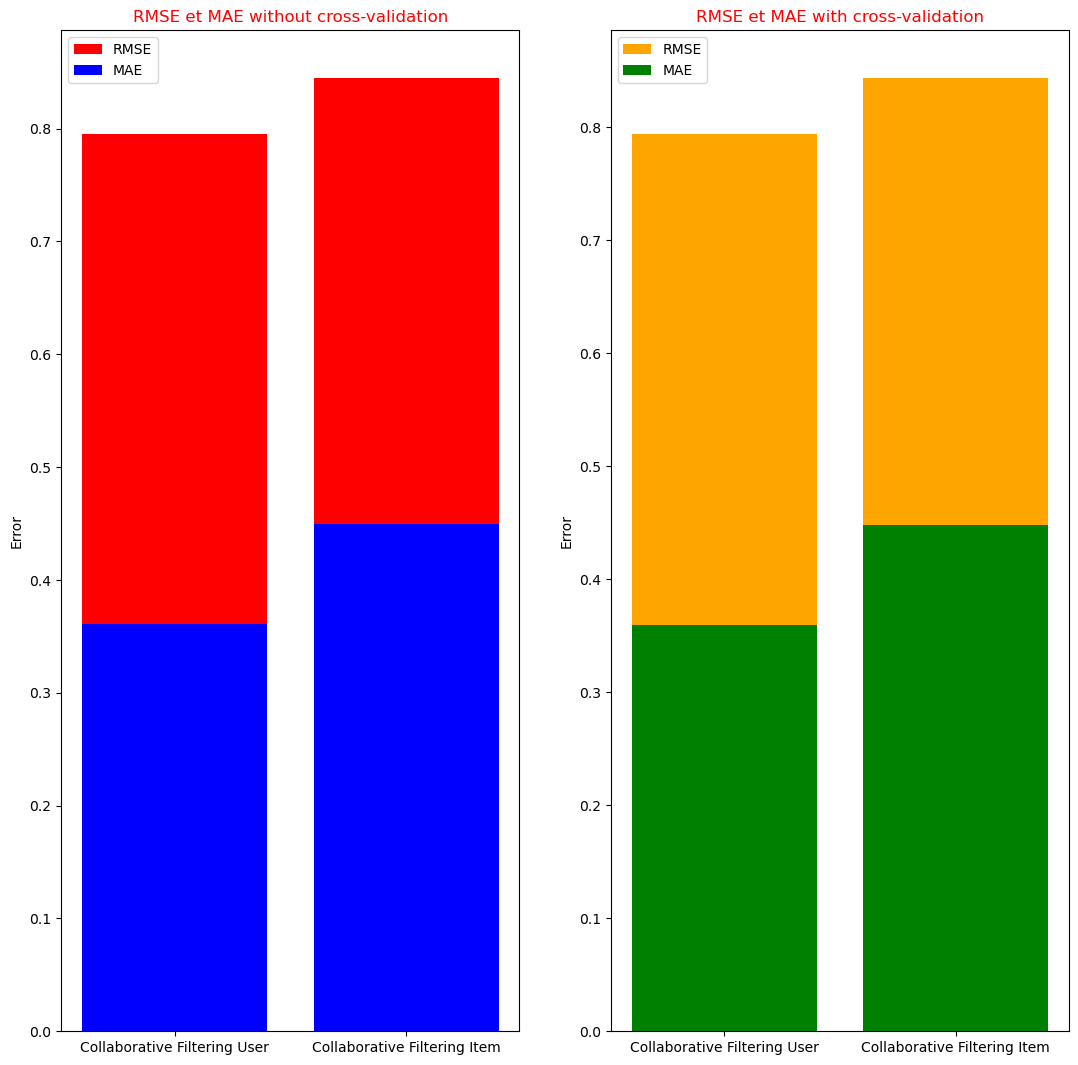

In [48]:
methodes=['Collaborative Filtering User','Collaborative Filtering Item'] ## Labels methods
# RMSE/ MAE without cross-validation
rmse_with_no_cv=[rmse_nocross_user,rmse_nocross_item]
mae_with_no_cv=[mae_nocross_user,mae_nocross_item]
# RMSE / MAE  with cross-validation
rmse_with_cv=list_RMSE_CF.mean(axis=0)
mae_with_cv=list_MAE_CF.mean(axis=0)
fig,ax=plt.subplots(1,2,figsize=(13,13))
ax[0].bar(methodes,rmse_with_no_cv,color='red',label='RMSE')
ax[0].bar(methodes,mae_with_no_cv,color='blue',label='MAE') 
ax[0].set_ylabel('Error')
ax[0].set_title('RMSE et MAE without cross-validation',c='red')
ax[0].legend()

ax[1].bar(methodes,rmse_with_cv,color='orange',label='RMSE')
ax[1].bar(methodes,mae_with_cv,color='green',label='MAE') 
ax[1].set_ylabel('Error')
ax[1].set_title('RMSE et MAE with cross-validation',c='red')
ax[1].legend()

In [49]:
# Retrieval of RMSE obtained with cross-validation for U-U and I-I approaches
rmse_user = list_RMSE_CF[:,0]  # RMSE U-U
rmse_item = list_RMSE_CF[:,1]  # RMSE I-I

# Sample size
n_user = len(rmse_user)
n_item = len(rmse_item)

# Mean calculation
mean_user = np.mean(rmse_user)
mean_item = np.mean(rmse_item)

# Std calculation
std_user = np.std(rmse_user, ddof=1) 
std_item = np.std(rmse_item, ddof=1)

# t-stats calculation
t_stat_with_numpy = (mean_user - mean_item) / np.sqrt((std_user**2 / n_user) + (std_item**2 / n_item))

# degree of freedom calculation
degree_of_freedom = (((std_user**2 / n_user) + (std_item**2 / n_item))**2) / (((std_user**2 / n_user)**2 / (n_user - 1)) + ((std_item**2 / n_item)**2 / (n_item - 1)))

# t-stats / p_value with scipy
t_stat, p_value=ttest_ind(rmse_user, rmse_item, equal_var=False)

# Displaying results
print(f"T-Statistic : {t_stat:.4f}")
print(f"P-value : {p_value:.4f}")

# statistic significativity verification
alpha = 0.05
if p_value < alpha:
    print("The différence between the  two methods is statistically significative.")
else:
    print("The différence between the  two methods is not statistically significative.")

T-Statistic : -10.0631
P-value : 0.0000
The différence between the  two methods is statistically significative.


**User-Based Approach**

In [51]:
## User-Based Approach
def prediction_user(V,W):
    V=V.copy()
    # Replacing nan with 0 to allow matricial calculation
    V[np.isnan(V)]=0
    # Matmul between u-i ratings and i-i sim
    rating_pred=np.dot(W,V)
    ## Normalization
    sum_weights=np.dot(W,~np.isnan(V)) ## Sum of similaritis for rated items
    sum_weights[sum_weights==0]=1e-10
    rating_pred=rating_pred/sum_weights
    rating_pred[np.isnan(V)]=np.nan
    return rating_pred

**Item-Based Approach**

In [53]:
## Approche Item
def prediction_item(V,W):
    V=V.copy()
    # Replacing nan with 0 to allow matricial calculation
    V[np.isnan(V)]=0
    # Matmul between u-i ratings and i-i sim
    rating_pred=np.dot(V,W)
    ## Normalization
    sum_weights=np.dot(~np.isnan(V),W) ## Sum of sim for users
    sum_weights[sum_weights==0]=1e-10
    rating_pred=rating_pred/sum_weights
    rating_pred[np.isnan(V)]=np.nan

    return rating_pred

**Similarity Matrices**

In [55]:
# U-U similarity computation
W_user = cosinus_matrices(MUI_numpy, MUI_numpy)

# I-I similarity computation
W_item = cosinus_matrices(MUI_numpy.T, MUI_numpy.T)

**Predictions**

In [57]:
# U-U Predictions
user_pred = prediction_user(MUI_numpy, W_user)

# I-I Predictions
item_pred = prediction_item(MUI_numpy, W_item)

# metrics calculation
mae_user = MAE(user_pred, MUI_numpy)
rmse_user = RMSE(user_pred, MUI_numpy)

mae_item = MAE(item_pred, MUI_numpy)
rmse_item = RMSE(item_pred, MUI_numpy)

# Displaying results
print("Performance metrics for User approach :")
print(f"MAE = {mae_user:.4f}")
print(f"RMSE = {rmse_user:.4f}")

print("\n Performance metrics for Item approach :")
print(f"MAE = {mae_item:.4f}")
print(f"RMSE = {rmse_item:.4f}")

Performance metrics for User approach :
MAE = 0.3606
RMSE = 0.7953

 Performance metrics for Item approach :
MAE = 0.4498
RMSE = 0.8449


**Graphics visualization**

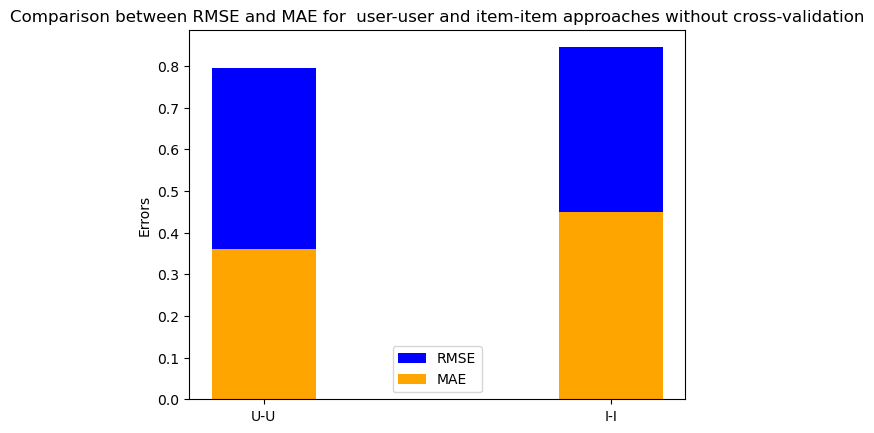

In [59]:
labels = ['U-U', 'I-I']
rmse_values = [rmse_user, rmse_item]
mae_values = [mae_user, mae_item]

x = range(len(labels))

plt.bar(x, rmse_values, width=0.3, label='RMSE', align='center', color='blue')
plt.bar(x, mae_values, width=0.3, label='MAE', align='center', color='orange')
plt.xticks(x, labels)
plt.ylabel("Errors")
plt.title("Comparison between RMSE and MAE for  user-user and item-item approaches without cross-validation")
plt.legend()

**Results Analysis:**

The results show that the user–user approach is overall more effective than the item–item approach. Specifically, the root mean square error (RMSE) is 0.7953 and the mean absolute error (MAE) is 0.3606 for the user–user approach, compared to an RMSE of 0.8449 and an MAE of 0.4498 for the item–item approach. These differences indicate that predictions from the user–user approach are, on average, closer to the actual ratings, both in terms of absolute errors and large deviations.

This can be explained by the fact that user preferences generally exhibit stronger correlations than item similarities, which can be affected by missing data for certain items. In this specific case, the user-user approach proves to be more effective. However, this finding is not necessarily generalizable to all datasets and should be reassessed in other contexts.

**Cross-validation**

In [62]:
# List to store cross-val results
list_RMSE_user = []
list_MAE_user = []
list_RMSE_item = []
list_MAE_item = []

for i in range(nbre_replis):
    # Training and test indices
    idx_train = np.concatenate([idx_split[j] for j in range(nbre_replis) if j != i])
    idx_test = idx_split[i]

    # Training and test matrices
    MUI_numpy_train = MUI_numpy_flatten.copy()
    MUI_numpy_test = MUI_numpy_flatten.copy()
    MUI_numpy_train[idx_test] = np.nan
    MUI_numpy_test[idx_train] = np.nan
    MUI_numpy_train = MUI_numpy_train.reshape(MUI_numpy.shape)
    MUI_numpy_test = MUI_numpy_test.reshape(MUI_numpy.shape)

    # similarities for the training set
    user_similarities = cosinus_matrices(MUI_numpy_train, MUI_numpy_train)  # U-U similarity
    item_similarities = cosinus_matrices(MUI_numpy_train.T, MUI_numpy_train.T)  # I-I similarity

    # U-U predictions
    predictions_user = prediction_user(MUI_numpy_train, user_similarities)
    rmse_user = RMSE(predictions_user, MUI_numpy_test)
    mae_user = MAE(predictions_user, MUI_numpy_test)
    list_RMSE_user.append(rmse_user)
    list_MAE_user.append(mae_user)

    # I-I predictions
    predictions_item = prediction_item(MUI_numpy_train, item_similarities)
    rmse_item = RMSE(predictions_item, MUI_numpy_test)
    mae_item = MAE(predictions_item, MUI_numpy_test)
    list_RMSE_item.append(rmse_item)
    list_MAE_item.append(mae_item)

# mean errors calculation
mean_RMSE_user = np.mean(list_RMSE_user)
mean_MAE_user = np.mean(list_MAE_user)
mean_RMSE_item = np.mean(list_RMSE_item)
mean_MAE_item = np.mean(list_MAE_item)

# results
print("Cross Validation : U-U Approach")
print(f"Average RMSE : {mean_RMSE_user}")
print(f"Average MAE : {mean_MAE_user}\n")

print("Cross Validation : I-I Approach")
print(f"Average RMSE : {mean_RMSE_item}")
print(f"Average MAE : {mean_MAE_item}\n")

Cross Validation : U-U Approach
Average RMSE : 0.809934952275394
Average MAE : 0.33455098962926366

Cross Validation : I-I Approach
Average RMSE : 0.8512853558270974
Average MAE : 0.404511861972744



**Result Analysis**

The obtained results allow for a comparison of the performance of the user–user and item–item approaches, both with and without cross-validation. For the user–user approach, the RMSE changes from 0.7953 without cross-validation to 0.8099 with cross-validation, while the MAE decreases from 0.3606 to 0.3346. For the item–item approach, the RMSE slightly increases from 0.8449 to 0.8512, and the MAE decreases from 0.4498 to 0.4045.

These results show a slight variation in the metrics, without any drastic changes, indicating that both methods maintain relatively stable performance even when subjected to cross-validation, a sign of robustness. However, the user–user approach remains globally superior, with lower errors in both configurations, confirming its ability to better capture similarities between users compared to those between items.

**Hypothesis Test**


- H0 : There is no significant difference between the RMSE of the two methods.
- H1 : There is a significant difference between the RMSE of the two methods.

In [66]:
# Retrieving   RMSE obtained  with cross-val for U-U and I-I approaches
rmse_user = list_RMSE_user  # RMSE u-u
rmse_item = list_RMSE_item  # RMSE i-i

rmse_user = np.array(rmse_user)
rmse_item = np.array(rmse_item)

# sample size
n_user = len(rmse_user)
n_item = len(rmse_item)

# mean calculation
mean_user = np.mean(rmse_user)
mean_item = np.mean(rmse_item)

# std calculation
std_user = np.std(rmse_user, ddof=1)  # ddof=1 pour un échantillon
std_item = np.std(rmse_item, ddof=1)

# t_stat calculation
t_stat_numpy = (mean_user - mean_item) / np.sqrt((std_user**2 / n_user) + (std_item**2 / n_item))
## t and p_value calculation (with scipy)
t_stat, p_value = ttest_ind(rmse_user, rmse_item, equal_var=False)
print(f"T-Statistic : {t_stat}")
print(f"P-value : {p_value}")


alpha = 0.05
if p_value < alpha:
    print("The différence between the two methods is statistically significative.")
else:
    print("The différence between the two methods is not  statistically significative.")

T-Statistic : -24.186267357303866
P-value : 1.1583604005732043e-08
The différence between the two methods is statistically significative.


**Bias correction for U-I**

In [68]:
## Expected mean calculation per user
user_means = np.nanmean(MUI, axis=1).reshape(-1, 1)  # Mean rating per user
user_means = np.where(np.isnan(user_means), np.nanmean(MUI), user_means)  # replacing nan with global mean
votes_moyenne_U_pred = np.tile(user_means, (1, MUI.shape[1]))  # extending user-mean to all the columns (items)

## Expected mean calculation per item
item_means = np.nanmean(MUI, axis=0).reshape(1, -1)  # Mean rating per item
item_means = np.where(np.isnan(item_means), np.nanmean(MUI), item_means)  # replacing nan with global mean
votes_moyenne_I_pred = np.tile(item_means, (MUI.shape[0], 1))  # extending user-mean to all the rows (user)

## Baseline expected vote
moyenne_U_repeat = votes_moyenne_U_pred
moyenne_I_repeat = votes_moyenne_I_pred

R_moy = 0.5 * (moyenne_U_repeat + moyenne_I_repeat)  # Combined user-item mean

# Displaying corrected baseline
print(f"Predictions corrigées (Baseline) : {R_moy}")

Predictions corrigées (Baseline) : [[1.22139477 0.51460792 0.43666518 ... 0.29297483 0.29350506 0.29350506]
 [0.99785137 0.29106452 0.21312178 ... 0.06943143 0.06996166 0.06996166]
 [0.97436742 0.26758057 0.18963783 ... 0.04594748 0.04647771 0.04647771]
 ...
 [0.95593698 0.24915013 0.17120739 ... 0.02751704 0.02804727 0.02804727]
 [1.02965874 0.32287189 0.24492915 ... 0.1012388  0.10176903 0.10176903]
 [1.09981332 0.39302647 0.31508373 ... 0.17139338 0.17192361 0.17192361]]


In [69]:
#User-Based approach
# Calculation of U-U matrix without bias
## Mean vote per user with ignoring nans
user_means=np.nanmean(MUI_numpy,axis=1).reshape(-1,1)
## extending mean user on all the columns
votes_Moyenne_U=np.tile(user_means,(1,MUI_numpy.shape[1]))

MUI_WB_U_U = MUI_numpy - votes_Moyenne_U
MUI_WB_U_U[np.isnan(MUI_WB_U_U)]=0 # replacing nan with 0 to allow matricial calculations
# Item-Based Approach
# Calculation of I-I matrix without bias
item_means=np.nanmean(MUI,axis=0).reshape(1,-1)
# # extending mean user on all the rows (each user) 
votes_Moyenne_I=np.tile(item_means,(MUI.shape[0],1))
MUI_WB_I_I = MUI_numpy.T - votes_Moyenne_I.T
MUI_WB_I_I[np.isnan(MUI_WB_I_I)]=0 # replacing nan with 0 to allow matricial calculations

**Errors calculation without cross-validation**

In [71]:
# U-U similarity calculation
W_user = cosinus_matrices(MUI_WB_U_U, MUI_WB_U_U)

# I-I similarity calculation
W_item = cosinus_matrices(MUI_WB_I_I, MUI_WB_I_I)

# U-U Predictions
user_pred = prediction_user(MUI_WB_U_U, W_user)

# I-I Predictions
item_pred = prediction_item(MUI_WB_I_I.T, W_item)

# metrics calculation
mae_user = MAE(user_pred, MUI_numpy)
rmse_user = RMSE(user_pred, MUI_numpy)

mae_item = MAE(item_pred, MUI_numpy)
rmse_item = RMSE(item_pred, MUI_numpy)

# Displaying results
print("Performance metrics without cross-validation \n ")
print("User Approach")
print(f"MAE = {mae_user:.4f}")
print(f"RMSE = {rmse_user:.4f}")
print("Item Approach")
print(f"MAE = {mae_item:.4f}")
print(f"RMSE = {rmse_item:.4f}")

Performance metrics without cross-validation 
 
User Approach
MAE = 0.3925
RMSE = 0.8189
Item Approach
MAE = 0.4772
RMSE = 1.7313


**Errors calculation with cross-validation**

In [73]:
# Initialization of lists for stocking results
list_RMSE_user = []
list_MAE_user = []
list_RMSE_item = []
list_MAE_item = []

# cross-validation over n_folds
for i in range(0,nbre_replis):
    # Training and test-indices
    idx_train = [idx for j, idx in enumerate(idx_split) if j != i]
    idx_train = np.concatenate(idx_train)
    idx_test = idx_split[i]

    # Training and Test Matrices
    MUI_numpy_train = MUI_numpy_flatten.copy()
    MUI_numpy_test = MUI_numpy_flatten.copy()
    MUI_numpy_train[idx_test] = np.nan  # Masking test indices in the training matrix
    MUI_numpy_test[idx_train] = np.nan  # Masking training indices in the testing matrix
    MUI_numpy_train = MUI_numpy_train.reshape(MUI_numpy.shape)
    MUI_numpy_test = MUI_numpy_test.reshape(MUI_numpy.shape)

    # Global mean calculation to handle empty columns
    global_mean = np.nanmean(MUI_numpy_train)

    # Handling empty columns by replacing by the global_mean
    empty_columns = np.where(np.sum(~np.isnan(MUI_numpy_train), axis=0) == 0)[0]
    for col in empty_columns:
        MUI_numpy_train[:, col] = global_mean

    # Global_mean for test matrix
    votes_moyenne_pred = np.full(MUI_numpy_test.shape, global_mean)

    # User-Based Approach : Mean rating per user
    user_means = np.nanmean(MUI_numpy_train, axis=1)
    user_means[np.isnan(user_means)] = global_mean
    votes_Moyenne_U = np.tile(user_means.reshape(-1, 1), (1, MUI_numpy_train.shape[1]))
    MUI_WB_U_U = MUI_numpy_train - votes_Moyenne_U
    MUI_WB_U_U[np.isnan(MUI_WB_U_U)] = 0

    # Item-Based Approach : Mean rating per item
    item_means = np.nanmean(MUI_numpy_train, axis=0)
    item_means[np.isnan(item_means)] = global_mean
    votes_Moyenne_I = np.tile(item_means.reshape(1, -1), (MUI_numpy_train.shape[0], 1))
    MUI_WB_I_I = MUI_numpy_train.T - votes_Moyenne_I.T
    MUI_WB_I_I[np.isnan(MUI_WB_I_I)] = 0

    # Sim calculation
    user_similarities = cosinus_matrices(MUI_WB_U_U, MUI_WB_U_U)  # Similarité utilisateur-utilisateur
    item_similarities = cosinus_matrices(MUI_WB_I_I, MUI_WB_I_I)  # Similarité item-item

    # U-U predictions
    predictions_user = prediction_user(MUI_WB_U_U, user_similarities)
    rmse_user = RMSE(predictions_user, MUI_numpy_test)
    mae_user = MAE(predictions_user, MUI_numpy_test)
    list_RMSE_user.append(rmse_user)
    list_MAE_user.append(mae_user)

    # I-I predictions
    predictions_item = prediction_item(MUI_WB_I_I.T, item_similarities)  # Alignement des dimensions
    rmse_item = RMSE(predictions_item, MUI_numpy_test)
    mae_item = MAE(predictions_item, MUI_numpy_test)
    list_RMSE_item.append(rmse_item)
    list_MAE_item.append(mae_item)

# Mean errors calculation for each approach
mean_RMSE_user = np.mean(list_RMSE_user)
mean_MAE_user = np.mean(list_MAE_user)
mean_RMSE_item = np.mean(list_RMSE_item)
mean_MAE_item = np.mean(list_MAE_item)

# Displaying results
print("Cross-validation: User-Based Approach")
print(f"Average RMSE : {mean_RMSE_user:.4f}")
print(f"Average MAE : {mean_MAE_user:.4f}\n")

print("Cross-validation: Item-Based Approach")
print(f"Average RMSE : {mean_RMSE_item:.4f}")
print(f"Average MAE  : {mean_MAE_item:.4f}\n")

Cross-validation: User-Based Approach
Average RMSE : 0.8374
Average MAE : 0.3607

Cross-validation: Item-Based Approach
Average RMSE : 3.1439
Average MAE  : 0.4831



The results show a marked difference between the performances of the user–user and item–item approaches, both with and without cross-validation.
For the user–user approach, without cross-validation, the MAE is 0.3925 and the RMSE is 0.8189, indicating generally reliable predictions with a relatively moderate quadratic error. When applying cross-validation, the MAE remains stable at 0.3607 and the RMSE increases slightly to 0.8374. This stability in errors suggests that the user–user approach tolerates variations in the training set well, demonstrating a certain level of robustness.

In contrast, the item–item approach yields much more inconsistent results. Without cross-validation, the MAE is 0.4772 and the RMSE is 1.7313, already showing significant errors and greater dispersion in predictions. These errors increase sharply with cross-validation: the RMSE jumps to 3.1439, while the MAE remains at 0.4831. This substantial increase indicates that the item–item approach is particularly sensitive to data splits, with performance degrading significantly when the evaluation is more rigorous.

Thus, in this experimental context, the user–user approach proves to be not only more accurate but also considerably more stable than the item–item approach.

**Hypothesis Test**

In [76]:
# Retrieving the RMSE obtained with cross-validation pour user and item based approaches
rmse_user = np.array(list_RMSE_user)  # RMSE U-U
rmse_item = np.array(list_RMSE_item)  # RMSE I-I

# sample size
n_user = len(rmse_user)
n_item = len(rmse_item)

# Mean calculation
mean_user = np.mean(rmse_user)
mean_item = np.mean(rmse_item)

# Std caluclation
std_user = np.std(rmse_user, ddof=1)  # ddof=1 for 1 sample
std_item = np.std(rmse_item, ddof=1)

# t_stats calculation
t_stat_numpy = (mean_user - mean_item) / np.sqrt((std_user**2 / n_user) + (std_item**2 / n_item))

t_stat, p_value = ttest_ind(rmse_user, rmse_item, equal_var=False)

print(f"T-Statistic : {t_stat}")
print(f"P-value : {p_value}")


alpha = 0.05
if p_value < alpha:
    print("The difference between the two methods is statistically significative")
else:
    print("The difference between the two methods is not statistically significative")

T-Statistic : -1.719049449609743
P-value : 0.160728638409402
The difference between the two methods is not statistically significative


## Adding Nearest Neighbors

In [78]:
def prediction_utilisateur_voisins(V, W, k=100):
    V = V.copy()
    V[np.isnan(V)] = 0  # Replacing nan with 0 to simplify calculation
    n_users,n_items=V.shape
    # Initialiazing the prediction matrix with zeros
    rating_pred=np.zeros_like(V)
    for user_idx in range(n_users):
        # Retrieve the similarity score for the current user
        user_sim=W[user_idx, :]
        # top k nearest neighbors  (descending order)
        k_nn_idx=np.argsort(-user_sim)[:k]
        
        for item_idx in range(n_items):
            # Filter neighbor indices that have ratings for this item
            valid_neighbors=k_nn_idx[V[k_nn_idx, item_idx] > 0]
            if len(valid_neighbors) == 0:  # if no valid neighbor skip
                rating_pred[user_idx, item_idx]=np.nan
                continue
            # Extract the rating and similarity weights of valid neighbors 
            neighbors_rating=V[valid_neighbors, item_idx]
            neighbors_weights=user_sim[valid_neighbors]

            # weighted average prediction calculation
            rating_pred[user_idx, item_idx]=np.sum(neighbors_rating * neighbors_weights) / np.sum(neighbors_weights)

    return rating_pred

**Error calculation without cross-validation**

In [80]:
# U-U sim
W_user = cosinus_matrices(MUI_numpy, MUI_numpy)

# U-U prediction with k neighbors
user_pred_k = prediction_utilisateur_voisins(MUI_numpy, W_user, k=100)

# metrics calculation without cross-validation
mae_user_k = MAE(user_pred_k, MUI_numpy)
rmse_user_k = RMSE(user_pred_k, MUI_numpy)
# graph visualization
rmseuser_no_cross_k=rmse_user_k
maeuser_no_cross_k=mae_user_k


# Displaying results
print("Performance metrics without cross-validation :")
print("User-Based Approach with K- neighbors :")
print(f"MAE = {mae_user_k:.4f}")
print(f"RMSE = {rmse_user_k:.4f}")

Performance metrics without cross-validation :
User-Based Approach with K- neighbors :
MAE = 2.8344
RMSE = 3.0546


**Error calculation with cross-validation**

In [82]:
# list initialization to stock results
list_RMSE_user_k = []
list_MAE_user_k = []

# cross-validation on n_folds
for i in range(0,nbre_replis):
    # Training and testing indices
    idx_train = [idx for j, idx in enumerate(idx_split) if j != i]
    idx_train = np.concatenate(idx_train)
    idx_test = idx_split[i]

    # Training and test matrices
    MUI_numpy_train = MUI_numpy_flatten.copy()
    MUI_numpy_test = MUI_numpy_flatten.copy()
    MUI_numpy_train[idx_test] = np.nan  # Removing testing indices in the training matrix
    MUI_numpy_test[idx_train] = np.nan  # Removing training indices in the testing matrix
    MUI_numpy_train = MUI_numpy_train.reshape(MUI_numpy.shape)
    MUI_numpy_test = MUI_numpy_test.reshape(MUI_numpy.shape)

    # U-U similarity for training matrix
    W_user_train = cosinus_matrices(MUI_numpy_train, MUI_numpy_train)

    # U-U prediction with k_neighbors
    predictions_user_k = prediction_utilisateur_voisins(MUI_numpy_train, W_user_train, k=100)

    # metrics calculation with cross-validation
    rmse_user_k = RMSE(predictions_user_k, MUI_numpy_test)
    mae_user_k = MAE(predictions_user_k, MUI_numpy_test)
    list_RMSE_user_k.append(rmse_user_k)
    list_MAE_user_k.append(mae_user_k)

# Mean error calculation
mean_RMSE_user_k = np.mean(list_RMSE_user_k)
mean_MAE_user_k = np.mean(list_MAE_user_k)

# Displaying results 
print("Cross-Validation : User-Based approach with k neighbors")
print(f"Average RMSE : {mean_RMSE_user_k:.4f}")
print(f"Average MAE : {mean_MAE_user_k:.4f}")

Cross-Validation : User-Based approach with k neighbors
Average RMSE : 3.0814
Average MAE : 2.8636


The results obtained for the user-based approach with k neighbors are generally satisfactory, both with and without cross-validation. Without cross-validation, the MAE reaches 2.8344, indicating that predictions deviate from the actual ratings by this value on average. The RMSE is 3.0546, slightly higher due to its greater sensitivity to large errors. When applying cross-validation, performance remains similar, with an average MAE of 2.8636 and an RMSE of 3.0814. These results suggest that the k-nearest neighbors approach maintains reasonable stability despite variations in the test sets. However, the errors remain non-negligible, which may indicate occasionally weak similarities or noise within the data. It would be worthwhile to consider further optimization of hyperparameters—particularly the number of neighbors, k—as well as more refined handling of missing values to further improve prediction accuracy.

In [84]:
## Item Based Approach with K-Neighbors
def prediction_item_voisins(V, W, k=100):
    V = V.copy()
    V[np.isnan(V)] = 0
    n_items, n_users = V.shape
    rating_pred = np.zeros_like(V)

    for item_idx in range(n_items):
        # Retrieve sim scores for the current item
        item_sim = W[item_idx, :]
        # Lim to k neighbors or less if k exceeds available size
        k_nn_idx = np.argsort(-item_sim)[:min(k, len(item_sim))]
        # Extracting rating from the neighbors
        neighbors_rating = V[:, k_nn_idx]
        # Corresponding sim weights
        neighbors_weights = item_sim[k_nn_idx]
        # weighted predictions
        weighted_sum = np.dot(neighbors_rating, neighbors_weights)
        sum_weights = np.sum(neighbors_weights)
        sum_weights = max(sum_weights, 1e-10)  ## Éviter division par 0
        rating_pred[:, item_idx] = weighted_sum / sum_weights
    return rating_pred.T

**Error calculation without cross-validation**

In [86]:
# sim I-I
W_item = cosinus_matrices(MUI_numpy.T, MUI_numpy.T)

# Predictions I-I with k neighbors
item_pred_k = prediction_item_voisins(MUI_numpy, W_item, k=100).T

# metrics calculations
mae_item_k = MAE(item_pred_k, MUI_numpy)
rmse_item_k = RMSE(item_pred_k, MUI_numpy)

rmse_item_nocross_k=rmse_item_k
mae_item_nocross_k=mae_item_k
# displaying results
print("Performance metrics without cross-validation:")
print("Item-Based Approach with K-neighbors :")
print(f"MAE = {mae_item_k:.4f}")
print(f"RMSE = {rmse_item_k:.4f}")

Performance metrics without cross-validation:
Item-Based Approach with K-neighbors :
MAE = 0.3372
RMSE = 0.7548


**Error calculation with cross-validation**

In [88]:
# Cross-validation over n_folds
list_RMSE_item_k = []
list_MAE_item_k = []

for i in range(0,nbre_replis):
    # Training and testing indices
    idx_train = [idx for j, idx in enumerate(idx_split) if j != i]
    idx_train = np.concatenate(idx_train)
    idx_test = idx_split[i]

    # Training and testing matrices
    MUI_numpy_train = MUI_numpy_flatten.copy()
    MUI_numpy_test = MUI_numpy_flatten.copy()
    MUI_numpy_train[idx_test] = np.nan  
    MUI_numpy_test[idx_train] = np.nan 
    MUI_numpy_train = MUI_numpy_train.reshape(MUI_numpy.shape)
    MUI_numpy_test = MUI_numpy_test.reshape(MUI_numpy.shape)

    # sim I-I for training matrix
    W_item_train = cosinus_matrices(MUI_numpy_train.T, MUI_numpy_train.T)

    # Predictions I-I with k neighbors
    predictions_item_k = prediction_item_voisins(MUI_numpy_train, W_item_train, k=100).T  # Transposition ici

    # metrics calculation for the current fold
    rmse_item_k = RMSE(predictions_item_k, MUI_numpy_test)
    mae_item_k = MAE(predictions_item_k, MUI_numpy_test)
    list_RMSE_item_k.append(rmse_item_k)
    list_MAE_item_k.append(mae_item_k)

# Mean error calculation with cross-val
mean_RMSE_item_k = np.mean(list_RMSE_item_k)
mean_MAE_item_k = np.mean(list_MAE_item_k)

# Displaying results
print("Cross validation : Item Based Approach with k neighbors")
print(f"Average RMSE :{mean_RMSE_item_k:.4f}")
print(f"Average MAE :{mean_MAE_item_k:.4f}")

Cross validation : Item Based Approach with k neighbors
Average RMSE :0.7628
Average MAE :0.3104


**Results Analysis:**

For the item–item approach based on k neighbors, the results obtained are generally satisfactory and demonstrate good predictive capability. Without cross-validation, the MAE is 0.3372 and the RMSE is 0.7548, indicating relatively low errors, both in terms of absolute mean error and the absence of significant outliers. This shows that incorporating k neighbors helps better weight the contributions of similar items to produce predictions closer to the actual values.

When cross-validation is applied, performance remains very good, with an RMSE of 0.7628 and an MAE of 0.3104. While the RMSE increases only slightly, the MAE improves, suggesting that the method gains in prediction consistency without being overly affected by the train/test splits.

These results highlight the robustness of the item–item approach with k neighbors, while also indicating that there is still room for improvement—particularly through better tuning of the k parameter or adapting the similarity computation to better reflect the diversity of the data.

**Graphics visualisation**

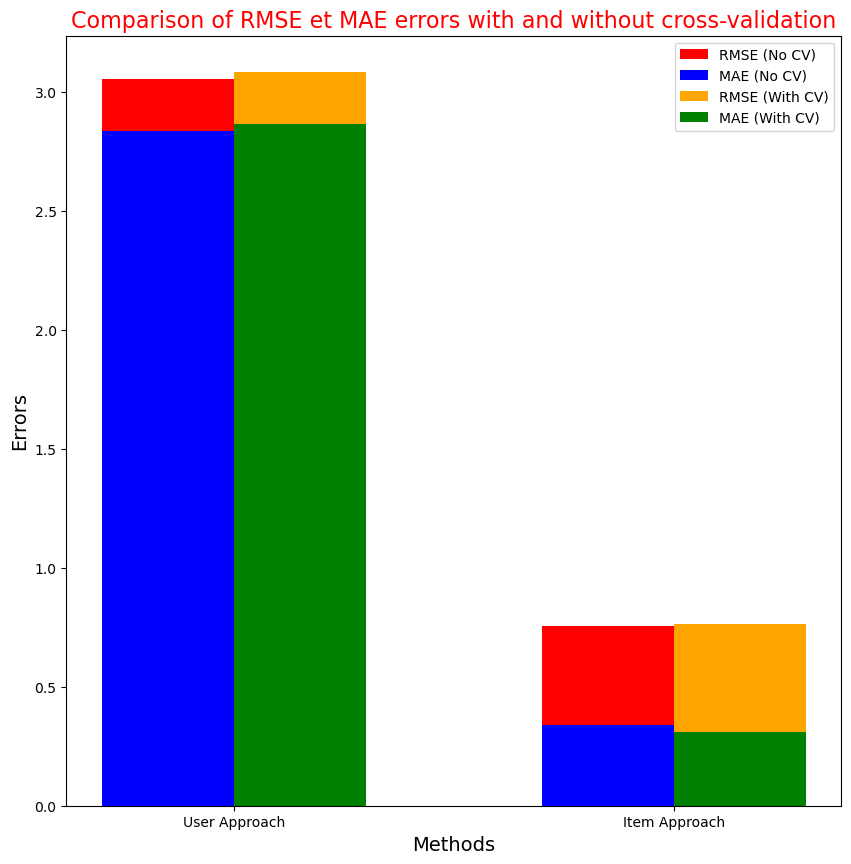

In [91]:
# Errors without cross-validation
rmse_no_cv=[rmseuser_no_cross_k,rmse_item_nocross_k]
mae_no_cv=[maeuser_no_cross_k, mae_item_nocross_k]

# Mean Errors with cross-validation
rmse_with_cv=[mean_RMSE_user_k,mean_RMSE_item_k]
mae_with_cv=[mean_MAE_user_k, mean_MAE_item_k]

# Approaches labels
approaches=['User Approach', 'Item Approach']

x=np.arange(len(approaches))
width=0.3
fig,ax=plt.subplots(figsize=(10, 10))

bars_rmse_no_cv=ax.bar(x-width/2,rmse_no_cv,width,label='RMSE (No CV)', color='red')
bars_mae_no_cv=ax.bar(x-width/2,mae_no_cv, width, label='MAE (No CV)', color='blue')

bars_rmse_with_cv=ax.bar(x + width/2, rmse_with_cv, width, label='RMSE (With CV)', color='orange')
bars_mae_with_cv=ax.bar(x + width/2, mae_with_cv, width, label='MAE (With CV)', color='green')

ax.set_xlabel('Methods', fontsize=14)
ax.set_ylabel('Errors', fontsize=14)
ax.set_title('Comparison of RMSE et MAE errors with and without cross-validation', fontsize=16, color='red')
ax.set_xticks(x)
ax.set_xticklabels(approaches)
ax.legend()

**Hypothesis Test**

In [93]:
# Retrieving the RMSE obtained with cross-validation for user and item based approaches
rmse_user = np.array(list_RMSE_user_k) # RMSE U-U
rmse_item = np.array(list_RMSE_item_k)  # RMSE I-i
# Sample size
n_user = len(rmse_user)
n_item = len(rmse_item)

# Mean calculation
mean_user = np.mean(rmse_user)
mean_item = np.mean(rmse_item)

# Std calculation
std_user = np.std(rmse_user, ddof=1)
std_item = np.std(rmse_item, ddof=1)

# t_stat calculation
t_stat_numpy = (mean_user - mean_item) / np.sqrt((std_user**2 / n_user) + (std_item**2 / n_item))

t_stat, p_value = ttest_ind(rmse_user, rmse_item, equal_var=False)

print(f"T-Statistic : {t_stat}")
print(f"P-value : {p_value}")


alpha = 0.05
if p_value < alpha:
    print("The difference between the two methods is statistically significative")
else:
    print("The difference between the two methods is not statistically significative")

T-Statistic : 589.9458231216184
P-value : 4.436069654687056e-12
The difference between the two methods is statistically significative
